In [198]:
import pyEDM as edm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error as mse

from parse_data import *
from ts_alignment import *
from ts_prediction import *
from feature_selection import *
from collect_predictions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
pd.set_option('mode.chained_assignment', None)

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 18
plt.rcParams["figure.figsize"] = (12, 7)

### Получение предсказаний (можно пропустить эту часть)

In [138]:
for SUBDIR in SUBDIRS:
    # parsing data from accelerometer and hyroscope
    dev_filename = f"./signals/{SUBDIR}.json"
    devices_data = parse_devices(dev_filename)
    
    # parsing data from video
    vid_filename = f"./encoded_video/{SUBDIR}.json"
    video_data = parse_video(vid_filename, KEYPOINTS_CNT)
    
    # alignment of time series
    cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
    small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)
    
    libsize = 700 if SUBDIR.startswith("chaotic") else 420
    predsize = 100 if SUBDIR.startswith("chaotic") else 60
    
    # CCM feature extraction and ts prediction
    extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                         k_feat_to_select=4, 
                                         devices_data=cut_devices_data, 
                                         video_data=video_data, 
                                         save_result=True, 
                                         filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")
    ccm_predict_ts(small_data, 
                   extra_feat_inds, 
                   libsize, 
                   predsize, 
                   Tp=1, 
                   subdir=SUBDIR)

    # PLS feature extraction and ts prediction
    pls_video = pls_feat_selection(libsize, 
                                   k_feat_to_select=4,                                   
                                   devices_data=cut_devices_data, 
                                   video_data=video_data)
    linear_predict_ts(pls_video, 
                      cut_devices_data, 
                      libsize, 
                      predsize, 
                      Tp=1, 
                      subdir=SUBDIR, 
                      latent_mode="pls")

    # CCA feature extraction and ts prediction
    cca_video = cca_feat_selection(libsize, 
                                   k_feat_to_select=4, 
                                   devices_data=cut_devices_data, 
                                   video_data=video_data)
    linear_predict_ts(cca_video, 
                      cut_devices_data, 
                      libsize, 
                      predsize, 
                      Tp=1, 
                      subdir=SUBDIR, 
                      latent_mode="cca")
    
    # Simple ts prediction
    naive_predict_ts(small_data, 
                     libsize, 
                     predsize, 
                     Tp=1, 
                     subdir=SUBDIR)

100%|███████████████████████████████████████████| 52/52 [00:18<00:00,  2.75it/s]


###  Эксперимент 0. Отрисовка исходных данных

Получение данных

In [163]:
SUBDIR = "cyclic_2"

# parsing data from accelerometer and hyroscope
dev_filename = f"./signals/{SUBDIR}.json"
devices_data = parse_devices(dev_filename)

# parsing data from video
vid_filename = f"./encoded_video/{SUBDIR}.json"
video_data = parse_video(vid_filename, KEYPOINTS_CNT)

# alignment of time series
cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)

Отрисовка показаний акселерометра и гироскопа

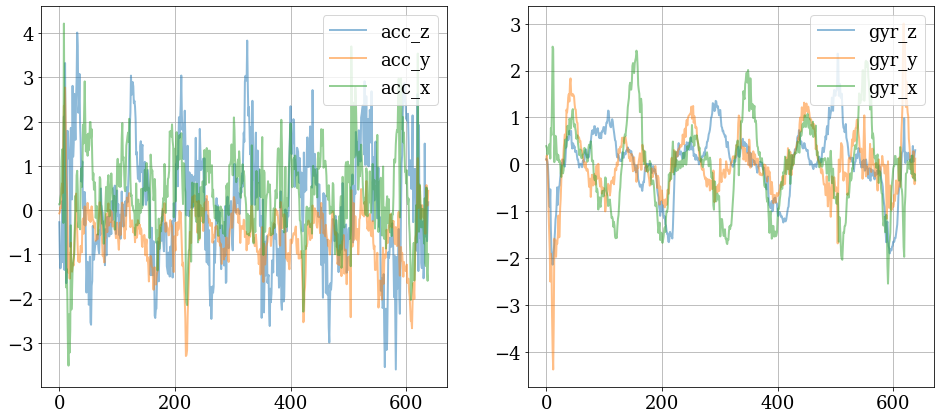

<Figure size 864x504 with 0 Axes>

In [164]:
plt.figure(figsize=(16, 7))

for i, target in enumerate(TARGET_COLUMNS):
    if i < 3:
        plt.subplot(121)
    else:        
        plt.subplot(122)
        
    plt.plot(small_data[target].values, alpha=0.5, label=target)
    
    plt.grid(True)
    plt.legend(loc="upper right")
    
plt.show()
plt.savefig("./images/cyclic_devices_data.png")

Отрисовка кейпоинтов, полученных по видео

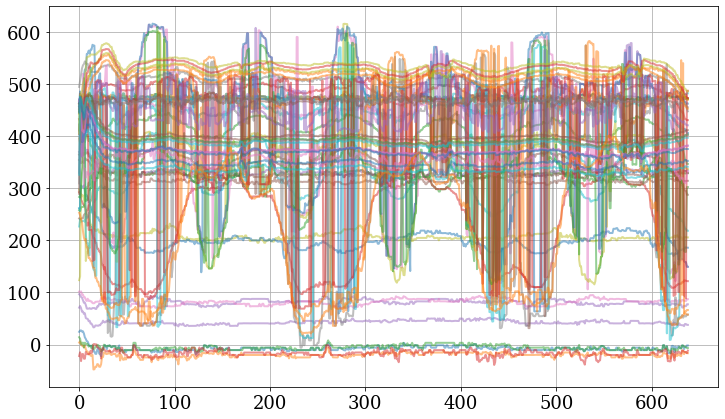

<Figure size 864x504 with 0 Axes>

In [165]:
for video_col in VIDEO_COLUMNS:
    plt.plot(small_data[video_col].values, alpha=0.5)
    
plt.grid(True)
plt.show()
plt.savefig("./images/cyclic_video_data.png")

### Эксперимент 1. Применение предсказательной модели в траекторном пространстве и его подпространстве

Получение предсказаний в траекторном пространстве

In [181]:
SUBDIR = 'chaotic_2'

# parsing data from accelerometer and hyroscope
dev_filename = f"./signals/{SUBDIR}.json"
devices_data = parse_devices(dev_filename)

# parsing data from video
vid_filename = f"./encoded_video/{SUBDIR}.json"
video_data = parse_video(vid_filename, KEYPOINTS_CNT)

# alignment of time series
cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)

libsize = 700 if SUBDIR.startswith("chaotic") else 420
predsize = 100 if SUBDIR.startswith("chaotic") else 60

extra_feat_inds = np.repeat(np.arange(video_data.shape[1])[None, :], 
                            TARGET_SIZE, 
                            axis=0)

ccm_predict_ts(small_data, 
               extra_feat_inds,
               libsize, 
               predsize, 
               Tp=1, 
               subdir=SUBDIR)

space_preds = collect_pred_from_diff_targets(SUBDIR, "ccm")
targets = space_preds.values[:, range(0, 11, 2)]
space_values = space_preds.values[:, range(1, 12, 2)]

Получение предскаазний в траекторном подпространстве

In [182]:
extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                     k_feat_to_select=4, 
                                     devices_data=cut_devices_data, 
                                     video_data=video_data, 
                                     read_result=True, 
                                     filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")

ccm_predict_ts(small_data, 
               extra_feat_inds,
               libsize, 
               predsize, 
               Tp=1, 
               subdir=SUBDIR)

subspace_preds = collect_pred_from_diff_targets(SUBDIR, "ccm")
subspace_values = subspace_preds.values[:, range(1, 12, 2)]

Сравнение полученных результатов

In [202]:
space_mse = mse(space_values, targets, multioutput='raw_values')
subspace_mse = mse(subspace_values, targets, multioutput='raw_values')

# space_mae = np.mean(np.absolute(space_values-targets), axis=0)
# subspace_mae = np.mean(np.absolute(subspace_values-targets), axis=0)

errors_data = np.concatenate([space_mse, 
                              subspace_mse]).reshape(2, -1)
errors = pd.DataFrame(data=errors_data, 
                      index=['space', 'subspace'],
                      columns=TARGET_COLUMNS)

errors.applymap(lambda val: round(val, 3))

,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x
space,1.053,0.401,0.483,0.084,0.090,0.063
subspace,0.315,0.043,0.150,0.001,0.015,0.001


### Эксперимент 2. Сравнение методов снижения размерности

Получение таблицы "метод / целевой признак"

In [232]:
SUBDIR = 'round_and_round'
res_columns = TARGET_COLUMNS
res_indices = PRED_METHODS
result_data = np.array([])

for TARGET in TARGET_COLUMNS:
    values = collect_pred_from_diff_methods(SUBDIR, TARGET).values
    targets = np.tile(values[:, 0].reshape(-1, 1), (1, len(PRED_METHODS)))
    values = values[:, 1:]
    
    target_mse = mse(values, targets, multioutput='raw_values')
    result_data = np.append(result_data, target_mse)
    
result_data = result_data.reshape(-1, len(PRED_METHODS))
table = pd.DataFrame(data=result_data, 
                     index=TARGET_COLUMNS, 
                     columns=PRED_METHODS)

table.applymap(lambda val: round(val, 3))

,ccm,pls,cca,naive
acc_z,0.282,0.777,0.897,0.549
acc_y,0.077,0.048,0.159,0.237
acc_x,0.126,0.407,0.636,0.133
gyr_z,0.013,0.013,0.045,0.016
gyr_y,0.043,0.042,0.029,0.014
gyr_x,0.018,0.022,0.103,0.028


Отрисовка предсказаний временного ряда

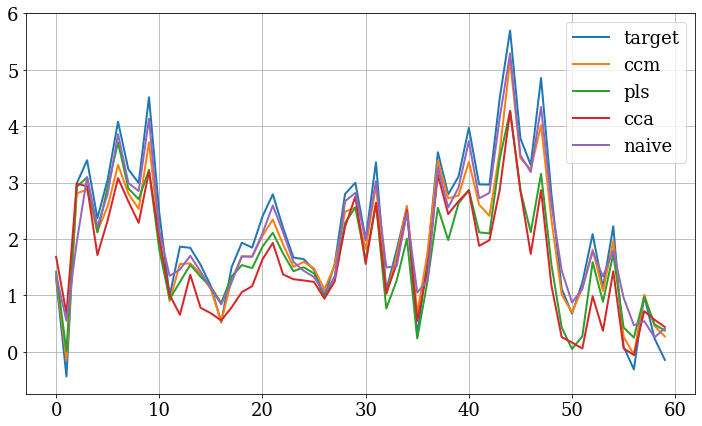

In [235]:
SUBDIR = 'round_and_round'
TARGET = 'acc_x'
preds = collect_pred_from_diff_methods(SUBDIR, TARGET)

for column in preds.columns:
    plt.plot(preds[column].values, label=column)

plt.grid(True)
plt.legend(loc="upper right")
plt.show()

### Отрисовка графиков с презентации

In [236]:
SUBDIR = "cyclic_2"
main_target_ind = 0
main_target = TARGET_COLUMNS[main_target_ind]
# parsing data from accelerometer and hyroscope
dev_filename = f"./signals/{SUBDIR}.json"
devices_data = parse_devices(dev_filename)

# parsing data from video
vid_filename = f"./encoded_video/{SUBDIR}.json"
video_data = parse_video(vid_filename, KEYPOINTS_CNT)

# alignment of time series
cut_devices_data, video_data = cut_devices_ts(devices_data, video_data)
small_data = pd.concat([cut_devices_data, video_data], axis=1, copy=False)

libsize = 700 if SUBDIR.startswith("chaotic") else 420
predsize = 100 if SUBDIR.startswith("chaotic") else 60

# CCM feature extraction and ts prediction
extra_feat_inds = ccm_feat_selection(libsize=libsize, 
                                     k_feat_to_select=4, 
                                     devices_data=cut_devices_data, 
                                     video_data=video_data, 
                                     read_result=True, 
                                     filename=f"./preds/{SUBDIR}/ccm/small_corr_mat.txt")

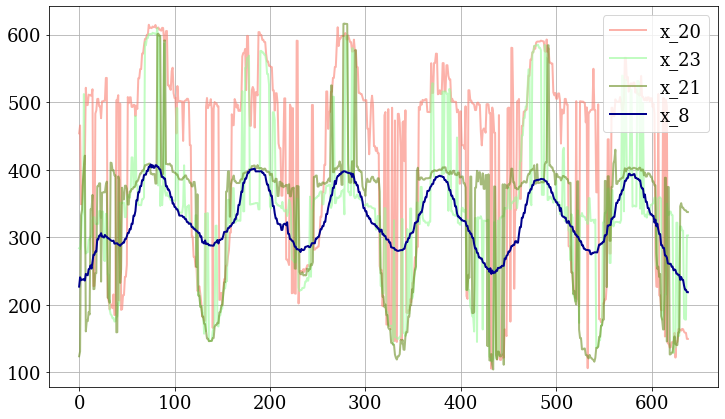

In [237]:
plt.figure()

colors = ("salmon", "palegreen", "olivedrab", "darkblue")

for ind, color in zip(extra_feat_inds[main_target_ind], colors):
    alpha = 1 if color == "darkblue" else 0.6
    
    plt.plot(video_data.iloc[:, ind].values, 
             label=video_data.columns[ind], 
             color=color,
             alpha=alpha)
    
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("images/source_ts_example.png")

/tmp/ipykernel_19419/2632684298.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


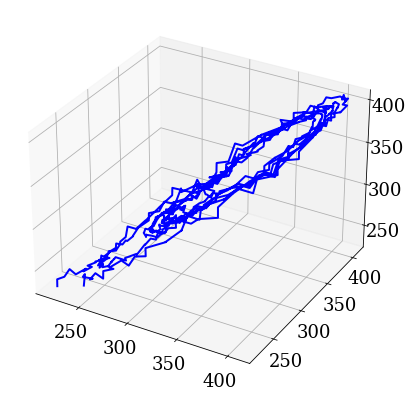

In [25]:
embed_source = edm.Embed(dataFrame=video_data.iloc[:, :], 
                         columns=video_data.columns[extra_feat_inds[main_target_ind, 3]], 
                         tau=-2,
                         E=3)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(embed_source.iloc[:, 0].values,
        embed_source.iloc[:, 1].values, 
        embed_source.iloc[:, 2].values, 
        color = "blue")
plt.savefig("images/3d_source.png")

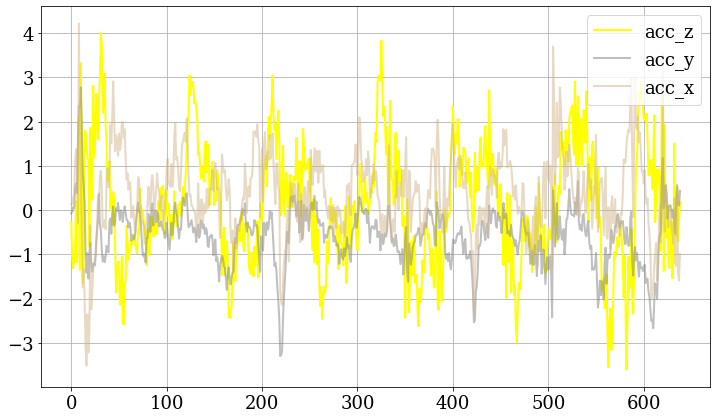

In [27]:
plt.figure()

colors = ("yellow", "gray", "tan")

for target, color in zip(TARGET_COLUMNS[:3], colors):
    alpha = 1 if target == main_target else 0.5
    
    plt.plot(cut_devices_data[target].values, 
             color=color, 
             label=target, 
             alpha=alpha)

plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("images/target_ts_example.png")

/tmp/ipykernel_19419/3048983359.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


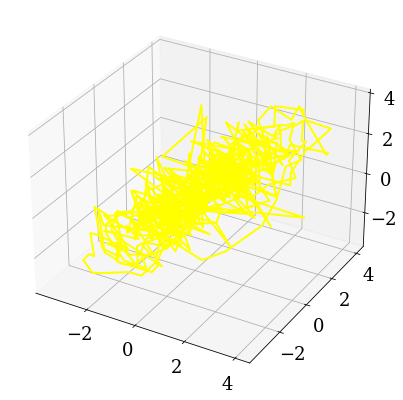

In [29]:
embed_target = edm.Embed(dataFrame=cut_devices_data.iloc[:, :], 
                         columns=[main_target], 
                         tau=-2,
                         E=3)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(embed_target.iloc[:, 0].values,
        embed_target.iloc[:, 1].values, 
        embed_target.iloc[:, 2].values, 
        color = "yellow")

plt.savefig("images/3d_target.png")